In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


: 

In [196]:
# run params
SECTION = 'gan'
RUN_ID = '0002'
DATA_NAME = 'horses'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


In [197]:
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7

In [198]:
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 6000
N_CRITIC = 5
CLIP_THRESHOLD = 0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True,drop_last=True )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [199]:
class Critic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 2)

        self.conv3 = nn.Conv2d(64, 128, 5, 2)
        self.conv4 = nn.Conv2d(128, 128, 5, 1)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2048, 1)
    
    def forward(self, x):
        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv1(x)
        x = F.leaky_relu(x)

        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv2(x)
        x = F.leaky_relu(x)

        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv3(x)
        x = F.leaky_relu(x)

        x = F.pad(x, (2, 2, 2, 2))
        x = self.conv4(x)
        x = F.leaky_relu(x)

        x = self.flatten(x)
        x = self.linear1(x)

        return x

In [200]:
Critic()(torch.randn(64, 3, 32,32)).shape

torch.Size([64, 1])

In [201]:
z_dim = 100
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.linear1 = nn.Linear(z_dim, 2048)
        self.bn1 = nn.BatchNorm1d(2048, momentum=0.8)
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2)

        self.conv1 = nn.Conv2d(128, 128, 5, 1)
        self.bn2 = nn.BatchNorm2d(128, momentum=0.8)
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)

        self.conv2 = nn.Conv2d(128, 64, 5, 1)
        self.bn3 = nn.BatchNorm2d(64, momentum=0.8)
        self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2)

        self.conv3 = nn.Conv2d(64, 32, 5, 1, 1)
        self.bn4 = nn.BatchNorm2d(32, momentum=0.8)
        self.convT2 = nn.ConvTranspose2d(32, 3, 5, 1, 2)

        
    def forward(self, x):
        x = self.bn1(self.linear1(x))
        x = F.leaky_relu(x)
        x = x.reshape(-1, 128, 4, 4)

        x = self.upsample1(x)
        
        x = F.pad(self.conv1(x), (2,2,2,2))
        
        x = self.bn2(x)
        x = F.leaky_relu(x)

        x = self.upsample2(x)
        
        x = F.pad(self.conv2(x), (2,2,2,2))
        
        x = F.leaky_relu(self.bn3(x))

        x = self.upsample3(x)
        x = F.pad(self.conv3(x), (1,1,1,1))
        
        x = F.leaky_relu(self.bn4(x))
        x = self.convT2(x)

        return torch.tanh(x)

In [202]:
Generator(100)(torch.randn((64, 100))).shape

torch.Size([64, 3, 32, 32])

In [203]:
critic = Critic().to(device)
generator =  Generator(100).to(device)
d_optimizer = optim.RMSprop(critic.parameters(),lr=0.00005)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

In [204]:
n_critic = 5
clip_threshold = 0.01

d_losses, g_losses = [], []
for epoch in range(6000):  # loop over the dataset multiple times
    g_total, d_total = 0., 0.
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs = inputs.to(device)
        real = torch.ones((BATCH_SIZE, 1)).to(device)
        fake = - torch.ones((BATCH_SIZE, 1)).to(device)
        for _ in range(n_critic):
            generator.eval()
            generated_images = generator(torch.randn((BATCH_SIZE, z_dim)).to(device))

            d_loss = - torch.mean(critic(generated_images) * real)
            d_loss -= torch.mean(critic(inputs) * fake)
            d_loss *= 0.5


            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            for p in critic.parameters():
                p.data.clamp_(-clip_threshold, clip_threshold)

        generator.train()
        critic.eval()
        real = torch.ones((BATCH_SIZE, 1)).to(device)
        generated_images = generator(torch.randn((BATCH_SIZE, z_dim)).to(device))

        g_loss = - torch.mean(critic(generated_images) *real)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        d_total += d_loss.item()
        g_total += g_loss.item()
    
    d_losses.append(d_total/len(trainloader))
    g_losses.append(g_total/len(trainloader))

    print(f'[{epoch + 1}] d_loss: {d_total / len(trainloader):.3f} g_loss: {g_total / len(trainloader):.3f}')
    torch.save(critic, RUN_FOLDER + "/weights/critic.pt")
    torch.save(generator, RUN_FOLDER + "/weights/generator.pt")


print('Finished Training')

[1] d_loss: -1518.275 g_loss: -2725.144
[2] d_loss: -1667.557 g_loss: -3025.244
[3] d_loss: -1668.632 g_loss: -3027.498
[4] d_loss: -1668.760 g_loss: -3027.751
[5] d_loss: -1668.759 g_loss: -3027.771
[6] d_loss: -1668.767 g_loss: -3027.770
[7] d_loss: -1668.767 g_loss: -3027.771
[8] d_loss: -1668.778 g_loss: -3027.772
[9] d_loss: -1668.766 g_loss: -3027.771
[10] d_loss: -1668.768 g_loss: -3027.771
[11] d_loss: -1668.777 g_loss: -3027.769
[12] d_loss: -1668.766 g_loss: -3027.772


KeyboardInterrupt: 

In [ ]:
critic(inputs).shape, fake.shape

(torch.Size([80, 1]), torch.Size([128, 1]))

In [ ]:
gen_imgs.shape

torch.Size([25, 3, 32, 32])

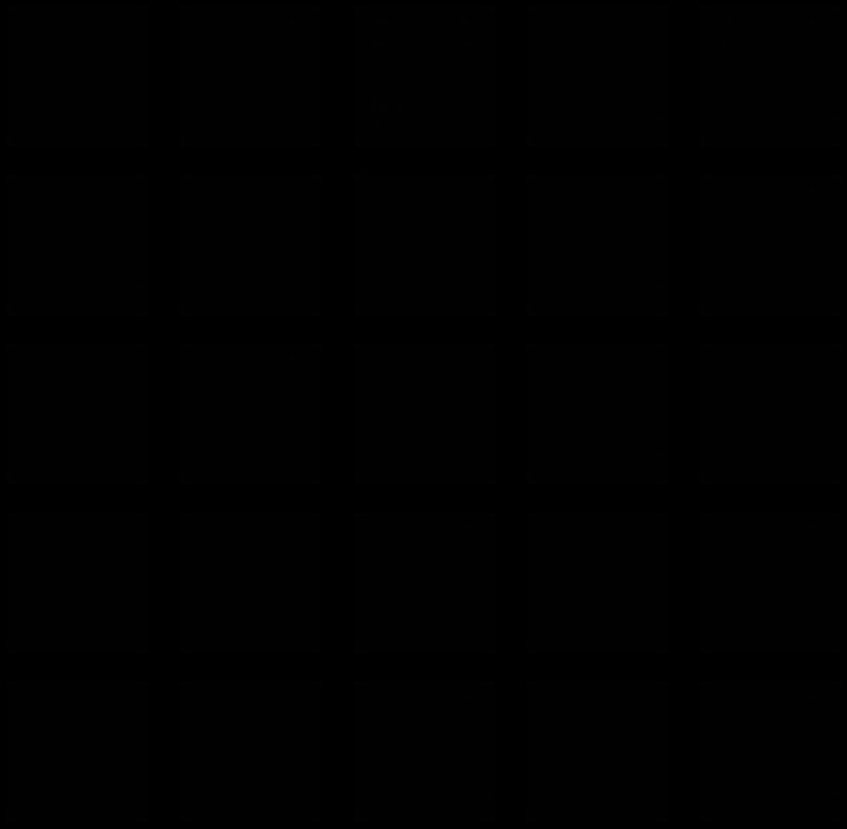

In [205]:
r, c = 5, 5
noise = torch.randn((r * c, z_dim)).to(device)
generator.eval()
gen_imgs = generator(noise)

transform1 = transforms.ToPILImage()

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        
        gen_img = transform1(gen_imgs[cnt])
        axs[i,j].imshow(np.squeeze(gen_img), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample_%d.png" % epoch))
# plt.close()

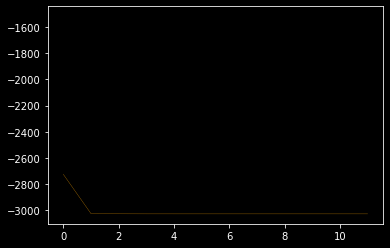

In [206]:
fig = plt.figure()
plt.plot([x for x in d_losses], color='black', linewidth=0.25)

plt.plot([x for x in g_losses], color='orange', linewidth=0.25)

plt.show()


In [207]:
def compare_images(img1, img2):
    return torch.mean(np.abs(img1 - img2))

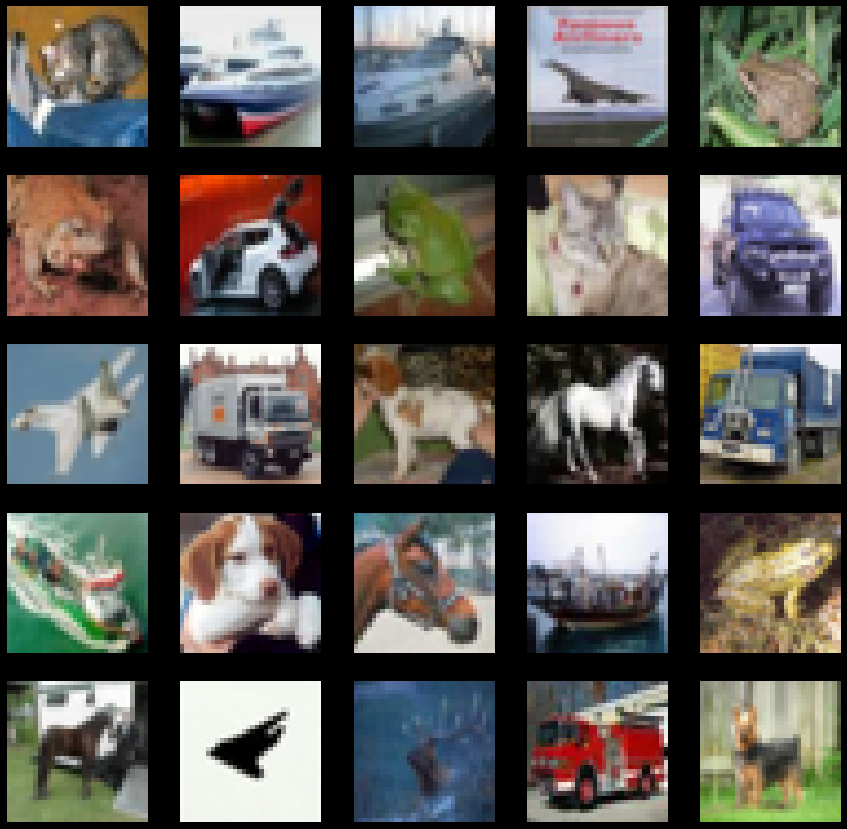

In [208]:

r, c = 5, 5

inputs_, _ = next(iter(testloader))

transform1 = transforms.ToPILImage()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        true_imgs = transform1(inputs_[cnt])


        axs[i,j].imshow(true_imgs, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
# plt.close()

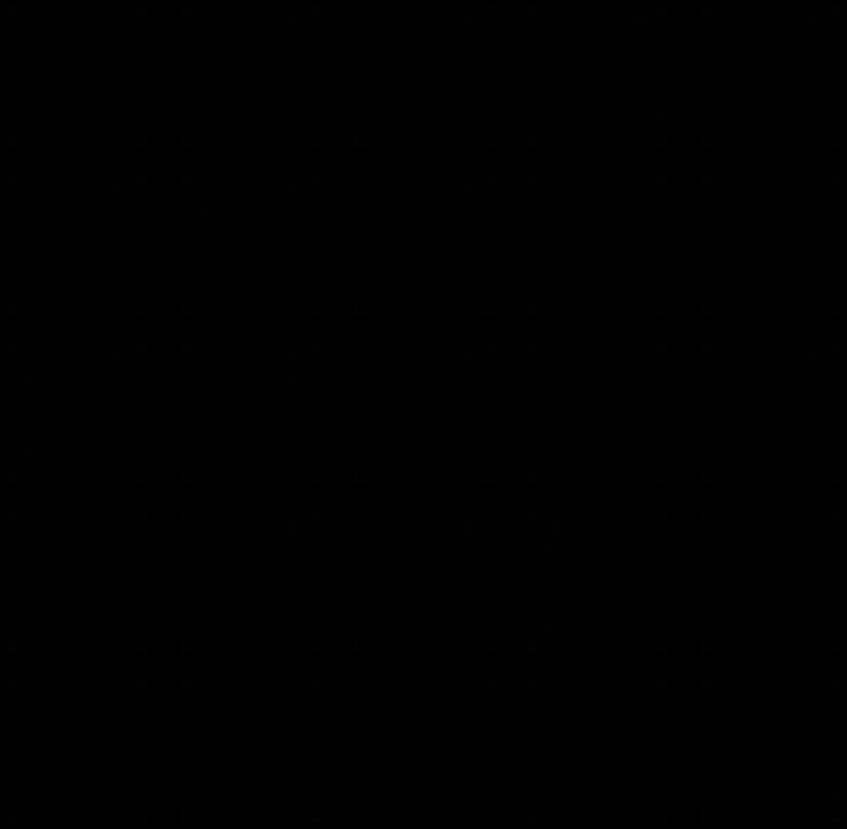

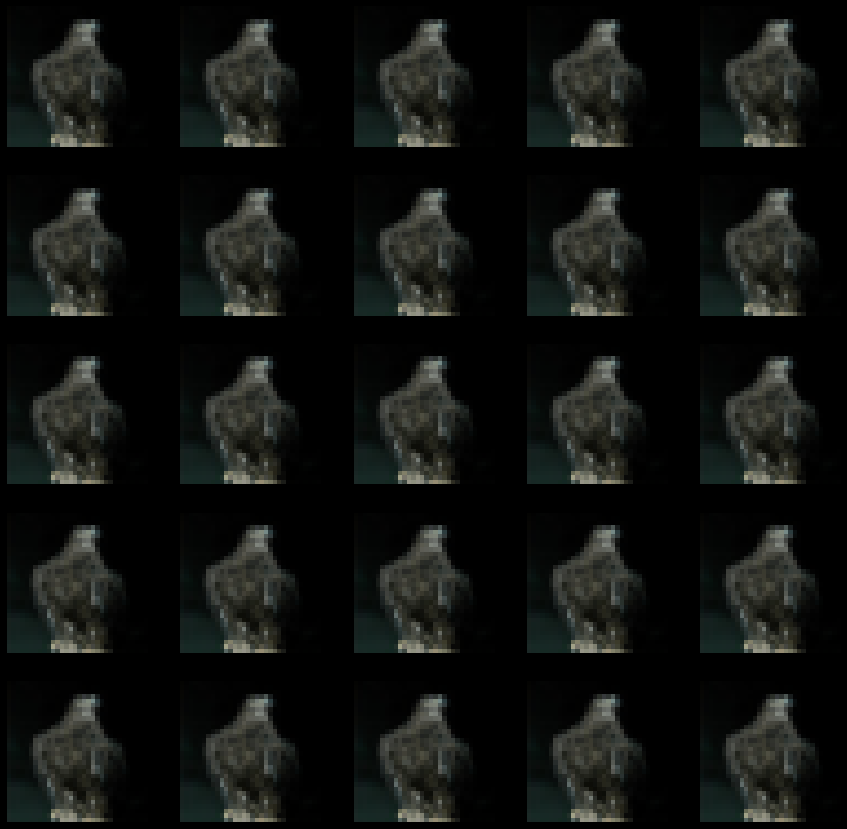

In [209]:
r, c = 5, 5
noise = torch.randn((r * c, z_dim)).to(device)
generator.eval()
gen_imgs = generator(noise)

#Rescale images 0 - 1
transform1 = transforms.ToPILImage()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        gen_img = transform1(gen_imgs[cnt])
        axs[i,j].imshow(np.squeeze(gen_img), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
# plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0
inputs_, _ = next(iter(testloader))
inputs_ = inputs_.to(device)
transform1 = transforms.ToPILImage()

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(inputs_):
            
            diff = torch.mean(torch.abs(gen_imgs - k).to(device)).to(device)
            if diff < c_diff:
                c_img = k.clone()
                c_diff = diff
        c_img = transform1(c_img)
        
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
# plt.close()